In [1]:
import endomill
import yaml


In [2]:
parameter_packs = (
    [
        {
            "MILL_TREATMENT_NAME": "bottleneck",
            "MILL_NPOP_SEQ": "[100] * 67 + [10] * 66 + [100] * 67",
            "MILL_REPLICATE": replicate,
        }
        for replicate in range(10)
    ]
    + [
        {
            "MILL_TREATMENT_NAME": "control",
            "MILL_REPLICATE": replicate,
        }
        for replicate in range(10)
    ]
    + [
        {
            "MILL_TREATMENT_NAME": "selection-pressure",
            "MILL_NTOURN_SEQ": "[8] * 67 + [1] * 66 + [8] * 67",
            "MILL_REPLICATE": replicate,
        }
        for replicate in range(10)
    ]
    + [
        {
            "MILL_TREATMENT_NAME": "range-expansion",
            "MILL_REPLICATE": replicate,
            "MILL_NPOP_SEQ": "[10] * 67 + [*range(10, 142, 2)] + [142] * 67",
        }
        for replicate in range(10)
    ]
)

for i, pp in enumerate(parameter_packs):
    with open(f"Ne-inference-parameterization-{i}.yaml", "w") as file:
        yaml.safe_dump(pp, file)
# endomill.instantiate_over(parameter_packs=parameter_packs)


# Papermill Parameters


In [3]:
MILL_NPOP_SEQ: str = "[100] * 200"
MILL_NTOURN_SEQ: str = "[2] * 200"
MILL_TREATMENT_NAME: str  # = "control"
MILL_REPLICATE: int  # = 0


In [4]:
# Parameters
MILL_NPOP_SEQ = "[10] * 67 + [*range(10, 142, 2)] + [142] * 67"
MILL_REPLICATE = 6
MILL_TREATMENT_NAME = "range-expansion"


In [5]:
MILL_NPOP_SEQ = eval(MILL_NPOP_SEQ)
MILL_NTOURN_SEQ = eval(MILL_NTOURN_SEQ)


# Global Setup


In [6]:
import copy
import math
import itertools as it
import typing
import random

import alifedata_phyloinformatics_convert as apc
from deap import algorithms as deap_algorithms
from deap import base as deap_base
from deap import creator as deap_creator
from deap import tools as deap_tools

from hstrat import hstrat
from iterpop import iterpop as ip
from keyname import keyname as kn
from matplotlib import pyplot as plt
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
from scipy import stats as scipy_stats
import seaborn as sns
import sympy
from teeplot import teeplot as tp
from tqdm import tqdm

import pylib


In [7]:
random.seed(MILL_REPLICATE)


In [8]:
nbm.print_metadata()


context: local
hostname: thinkpad
interpreter: 3.10.6 (main, Mar 10 2023, 10:55:28) [GCC 11.3.0]
nbcellexec: null
nbname: None
nbpath: None
revision: null
session: 143f0650-afe2-4f73-bd2d-ce7bceb19424
timestamp: 2023-05-23T13:03:27Z00:00




IPython==8.13.2
keyname==0.5.2
yaml==6.0
alifedata_phyloinformatics_convert==0.13.0
deap==1.3
endomill==0.1.3
hstrat==1.6.1
iterpop==0.4.1
matplotlib==3.7.1
nbmetalog==0.2.6
numpy==1.24.3
pandas==2.0.1
scipy==1.10.1
seaborn==0.12.2
sympy==1.12
teeplot==0.5.0
re==2.2.1
comm==0.1.3
logging==0.5.1.2
psutil==5.9.5
zmq==25.0.2
json==2.0.9
ipykernel==6.23.1


# Parameters


In [9]:
# HSTRAT_RESOLUTION = None
HSTRAT_DIFFERENTIA_WIDTH = 64
NGEN = ip.pophomogeneous([len(MILL_NPOP_SEQ), len(MILL_NTOURN_SEQ)])


# Setup


In [10]:
deap_creator.create("FitnessMax", deap_base.Fitness, weights=(1.0,))
deap_creator.create("Individual", list, fitness=deap_creator.FitnessMax)

toolbox = deap_base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register(
    "individual",
    deap_tools.initRepeat,
    deap_creator.Individual,
    toolbox.attr_bool,
    n=100,
)
toolbox.register("population", deap_tools.initRepeat, list, toolbox.individual)


def evalOneMax(individual):
    return (sum(individual),)


toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", deap_tools.cxTwoPoint)
toolbox.register("mutate", deap_tools.mutFlipBit, indpb=0.05)

# Decorate the variation operators
history = deap_tools.History()
toolbox.decorate("mate", history.decorator)

toolbox.decorate("mate", pylib.deap.hstrat_mate_decorator)


# Evolve


In [11]:
# Create the population and populate the history
population = toolbox.population(n=MILL_NPOP_SEQ[0])

species_ancestor = hstrat.HereditaryStratigraphicColumn(
    stratum_retention_policy=hstrat.perfect_resolution_algo.Policy(),
    stratum_differentia_bit_width=HSTRAT_DIFFERENTIA_WIDTH,
)
gene_ancestor = hstrat.HereditaryStratigraphicColumn(
    stratum_retention_policy=hstrat.perfect_resolution_algo.Policy(),
    stratum_differentia_bit_width=HSTRAT_DIFFERENTIA_WIDTH,
    initial_stratum_annotation=0,
)
for member in population:
    member.species_annotation = species_ancestor.CloneDescendant()
    member.gene_annotation = gene_ancestor.CloneDescendant(0)

history.update(population)

# Do the evolution, the decorators will take care of updating the
# history
for _gen, (NPOP, NTOURN) in tqdm(
    enumerate(
        zip(
            MILL_NPOP_SEQ,
            MILL_NTOURN_SEQ,
        )
    )
):
    toolbox.register("select", deap_tools.selTournament, tournsize=NTOURN)
    offspring = deap_algorithms.varAnd(
        population, toolbox, cxpb=1.0, mutpb=1.0,
    )
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=NPOP)
    population = [copy.deepcopy(ind) for ind in population]

# ensure all extant organisms registered with phylogeny tracker
for x in population:
    history.update([x])


0it [00:00, ?it/s]

3it [00:00, 21.16it/s]

6it [00:00, 19.25it/s]

8it [00:00, 18.20it/s]

10it [00:00, 17.07it/s]

12it [00:00, 16.01it/s]

14it [00:00, 15.02it/s]

16it [00:00, 15.18it/s]

18it [00:01, 16.38it/s]

21it [00:01, 17.83it/s]

23it [00:01, 13.56it/s]

25it [00:01, 14.42it/s]

27it [00:01, 15.18it/s]

29it [00:01, 15.39it/s]

31it [00:01, 15.60it/s]

33it [00:02, 15.33it/s]

35it [00:02, 15.21it/s]

37it [00:02, 15.02it/s]

39it [00:02, 14.39it/s]

41it [00:02, 13.83it/s]

43it [00:02, 10.34it/s]

45it [00:03, 10.77it/s]

47it [00:03, 11.16it/s]

49it [00:03, 11.36it/s]

51it [00:03,  9.99it/s]

53it [00:04,  8.29it/s]

54it [00:04,  7.72it/s]

55it [00:04,  7.20it/s]

56it [00:04,  6.78it/s]

57it [00:04,  6.41it/s]

58it [00:04,  6.09it/s]

59it [00:05,  4.52it/s]

60it [00:05,  4.70it/s]

61it [00:05,  4.84it/s]

62it [00:05,  4.92it/s]

63it [00:06,  4.95it/s]

64it [00:06,  4.90it/s]

65it [00:06,  4.92it/s]

66it [00:06,  4.95it/s]

67it [00:06,  4.81it/s]

68it [00:07,  4.79it/s]

69it [00:07,  4.53it/s]

70it [00:07,  4.22it/s]

71it [00:07,  3.86it/s]

72it [00:08,  2.80it/s]

73it [00:08,  2.66it/s]

74it [00:09,  2.48it/s]

75it [00:09,  2.26it/s]

76it [00:10,  2.12it/s]

77it [00:11,  2.04it/s]

78it [00:11,  1.98it/s]

79it [00:12,  2.11it/s]

80it [00:12,  2.04it/s]

81it [00:12,  2.15it/s]

82it [00:13,  2.28it/s]

83it [00:13,  2.11it/s]

84it [00:14,  1.88it/s]

85it [00:15,  1.61it/s]

86it [00:16,  1.37it/s]

87it [00:16,  1.44it/s]

88it [00:17,  1.27it/s]

89it [00:18,  1.22it/s]

90it [00:20,  1.06it/s]

91it [00:21,  1.00it/s]

92it [00:22,  1.08s/it]

93it [00:23,  1.19s/it]

94it [00:25,  1.21s/it]

95it [00:26,  1.15s/it]

96it [00:27,  1.25s/it]

97it [00:29,  1.31s/it]

98it [00:30,  1.40s/it]

99it [00:32,  1.55s/it]

100it [00:34,  1.51s/it]

101it [00:36,  1.69s/it]

102it [00:38,  1.74s/it]

103it [00:39,  1.78s/it]

104it [00:42,  1.91s/it]

105it [00:44,  1.91s/it]

106it [00:46,  2.10s/it]

107it [00:48,  2.10s/it]

108it [00:50,  2.07s/it]

109it [00:53,  2.21s/it]

110it [00:55,  2.24s/it]

111it [00:57,  2.29s/it]

112it [01:01,  2.77s/it]

113it [01:05,  3.02s/it]

114it [01:09,  3.37s/it]

115it [01:13,  3.50s/it]

116it [01:17,  3.79s/it]

117it [01:22,  3.93s/it]

118it [01:26,  3.97s/it]

119it [01:31,  4.26s/it]

120it [01:35,  4.25s/it]

121it [01:39,  4.24s/it]

122it [01:44,  4.57s/it]

123it [01:49,  4.53s/it]

124it [01:55,  4.86s/it]

125it [01:59,  4.85s/it]

126it [02:04,  4.91s/it]

127it [02:10,  5.20s/it]

128it [02:15,  5.15s/it]

129it [02:20,  5.16s/it]

130it [02:26,  5.33s/it]

131it [02:31,  5.28s/it]

132it [02:37,  5.53s/it]

133it [02:43,  5.41s/it]

134it [02:47,  5.16s/it]

135it [02:53,  5.24s/it]

136it [02:57,  4.89s/it]

137it [03:02,  5.03s/it]

138it [03:09,  5.74s/it]

139it [03:16,  6.03s/it]

140it [03:23,  6.20s/it]

141it [03:30,  6.62s/it]

142it [03:36,  6.45s/it]

143it [03:43,  6.64s/it]

144it [03:52,  7.20s/it]

145it [03:59,  7.21s/it]

146it [04:06,  7.15s/it]

147it [04:14,  7.22s/it]

148it [04:21,  7.28s/it]

149it [04:27,  6.95s/it]

150it [04:33,  6.72s/it]

151it [04:41,  7.00s/it]

152it [04:47,  6.73s/it]

153it [04:53,  6.59s/it]

154it [05:00,  6.49s/it]

155it [05:07,  6.84s/it]

156it [05:13,  6.57s/it]

157it [05:20,  6.50s/it]

158it [05:26,  6.57s/it]

159it [05:35,  7.29s/it]

160it [05:42,  7.11s/it]

161it [05:49,  7.02s/it]

162it [05:55,  6.91s/it]

163it [06:03,  7.24s/it]

164it [06:10,  7.01s/it]

165it [06:17,  6.93s/it]

166it [06:23,  6.88s/it]

167it [06:33,  7.59s/it]

168it [06:40,  7.37s/it]

169it [06:46,  7.20s/it]

170it [06:53,  7.03s/it]

171it [06:59,  6.58s/it]

172it [07:04,  6.13s/it]

173it [07:09,  5.82s/it]

174it [07:12,  5.13s/it]

175it [07:17,  5.05s/it]

176it [07:22,  5.09s/it]

177it [07:29,  5.51s/it]

178it [07:33,  5.00s/it]

179it [07:37,  4.77s/it]

180it [07:43,  5.14s/it]

181it [07:50,  5.73s/it]

182it [08:00,  7.01s/it]

183it [08:07,  6.95s/it]

184it [08:15,  7.40s/it]

185it [08:23,  7.66s/it]

186it [08:32,  7.85s/it]

187it [08:43,  8.86s/it]

188it [08:51,  8.53s/it]

189it [08:58,  8.30s/it]

190it [09:07,  8.28s/it]

191it [09:15,  8.21s/it]

192it [09:23,  8.12s/it]

193it [09:33,  8.84s/it]

194it [09:42,  8.78s/it]

195it [09:50,  8.59s/it]

196it [09:57,  8.22s/it]

197it [10:03,  7.58s/it]

198it [10:14,  8.53s/it]

199it [10:21,  8.01s/it]

200it [10:26,  7.22s/it]

200it [10:26,  3.13s/it]

# Reconstruction


In [12]:
extant_nodes = [individual.history_index for individual in population]
reconstructed_df = hstrat.build_tree(
    [individual.species_annotation for individual in population],
    version_pin=hstrat.__version__,
    force_common_ancestry=True,
    taxon_labels=map(str, extant_nodes),
)
reconstructed_df["name"] = reconstructed_df["taxon_label"]
reconstructed_df


,id,ancestor_list,origin_time,taxon_label,ancestor_id,name
0,0,[none],0.0,Root,0,Root
190,190,[0],189.0,Inner+r=189+d=PVG3oJTPe9J+uid=D7tB0UQlU6MyN0de...,0,Inner+r=189+d=PVG3oJTPe9J+uid=D7tB0UQlU6MyN0de...
195,195,[190],192.0,Inner+r=192+d=PUSAsaBZqkL+uid=tdcJdAeoGOXxqR6c...,190,Inner+r=192+d=PUSAsaBZqkL+uid=tdcJdAeoGOXxqR6c...
196,196,[190],192.0,Inner+r=192+d=PUSAsaBZqkL+uid=Bw0H66tztgYuTUrY...,190,Inner+r=192+d=PUSAsaBZqkL+uid=Bw0H66tztgYuTUrY...
200,200,[196],193.0,Inner+r=193+d=PfNdoa-aAOn+uid=UAvkc7OnY7eO7pDb...,196,Inner+r=193+d=PfNdoa-aAOn+uid=UAvkc7OnY7eO7pDb...
...,...,...,...,...,...,...
707,707,[425],201.0,15135,425,15135
708,708,[425],201.0,15066,425,15066
709,709,[425],201.0,15075,425,15075
710,710,[213],201.0,15086,213,15086


teeplots/./notebook=ne-inference+replicate=6+treatment=range-expansion+type=reconstruction+viz=draw-biopython-tree+ext=.pdf


teeplots/./notebook=ne-inference+replicate=6+treatment=range-expansion+type=reconstruction+viz=draw-biopython-tree+ext=.png


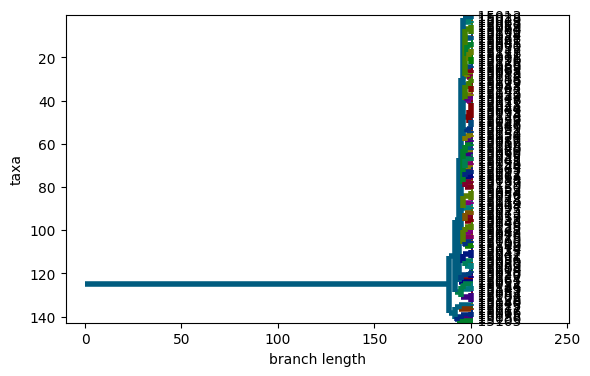

In [13]:
reconstructed_tree = apc.alife_dataframe_to_biopython_tree(
    reconstructed_df, setup_branch_lengths=True
)
plt.rcdefaults()
plt.close('all')
plt.clf()
tp.tee(
    pylib.tree.draw_biopython_tree,
    reconstructed_tree,
    teeplot_outattrs={
        "notebook": "ne-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "reconstruction",
    },
)


teeplots/./drop_overlapping_labels=true+notebook=ne-inference+replicate=6+treatment=range-expansion+type=reconstruction+viz=draw-biopython-tree+ext=.pdf


teeplots/./drop_overlapping_labels=true+notebook=ne-inference+replicate=6+treatment=range-expansion+type=reconstruction+viz=draw-biopython-tree+ext=.png


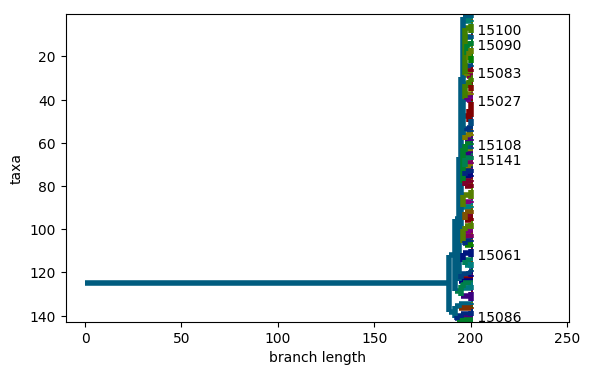

In [14]:
reconstructed_tree = apc.alife_dataframe_to_biopython_tree(
    reconstructed_df, setup_branch_lengths=True
)
plt.rcdefaults()
plt.close('all')
plt.clf()
tp.tee(
    pylib.tree.draw_biopython_tree,
    reconstructed_tree,
    drop_overlapping_labels=True,
    teeplot_outattrs={
        "drop_overlapping_labels": "true",
        "notebook": "ne-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "reconstruction",
    },
)


teeplots/./max_leaves=20+notebook=ne-inference+replicate=6+treatment=range-expansion+type=reconstruction+viz=draw-biopython-tree+ext=.pdf


teeplots/./max_leaves=20+notebook=ne-inference+replicate=6+treatment=range-expansion+type=reconstruction+viz=draw-biopython-tree+ext=.png


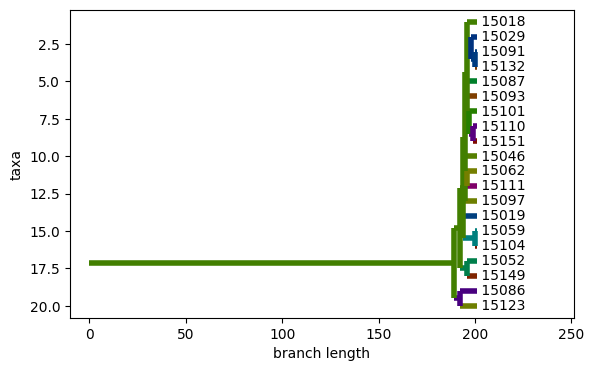

In [15]:
reconstructed_tree = apc.alife_dataframe_to_biopython_tree(
    reconstructed_df, setup_branch_lengths=True
)
plt.rcdefaults()
plt.close('all')
plt.clf()
tp.tee(
    pylib.tree.draw_biopython_tree,
    reconstructed_tree,
    max_leaves=20,
    teeplot_outattrs={
        "max_leaves": "20",
        "notebook": "ne-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "reconstruction",
    },
)


# Actual Pedigree


In [16]:
distilled_tree = pylib.deap.history_to_tree_upgma(history, extant_nodes)


teeplots/./notebook=ne-inference+replicate=6+treatment=range-expansion+type=distilled-reference+viz=draw-biopython-tree+ext=.pdf


teeplots/./notebook=ne-inference+replicate=6+treatment=range-expansion+type=distilled-reference+viz=draw-biopython-tree+ext=.png


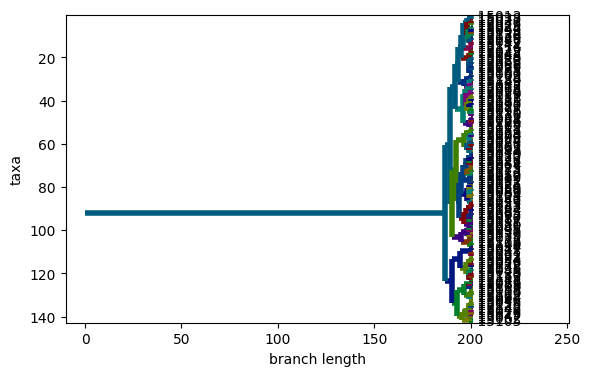

In [17]:
plt.rcdefaults()
plt.close('all')
plt.clf()
tp.tee(
    pylib.tree.draw_biopython_tree,
    distilled_tree,
    teeplot_outattrs={
        "notebook": "ne-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "distilled-reference",
    },
)


teeplots/./drop_overlapping_labels=true+notebook=ne-inference+replicate=6+treatment=range-expansion+type=distilled-reference+viz=draw-biopython-tree+ext=.pdf


teeplots/./drop_overlapping_labels=true+notebook=ne-inference+replicate=6+treatment=range-expansion+type=distilled-reference+viz=draw-biopython-tree+ext=.png


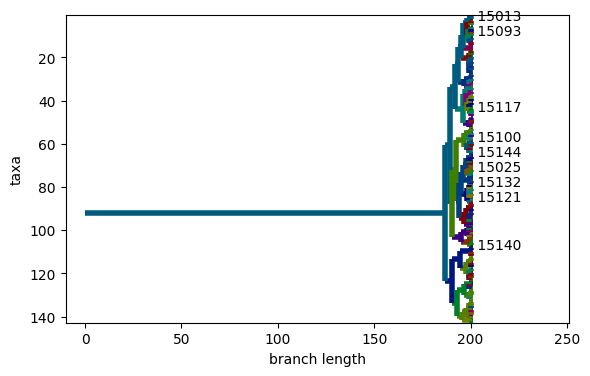

In [18]:
tp.tee(
    pylib.tree.draw_biopython_tree,
    distilled_tree,
    drop_overlapping_labels=True,
    teeplot_outattrs={
        "drop_overlapping_labels": "true",
        "notebook": "ne-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "distilled-reference",
    },
)


teeplots/./max_leaves=20+notebook=ne-inference+replicate=6+treatment=range-expansion+type=distilled-reference+viz=draw-biopython-tree+ext=.pdf


teeplots/./max_leaves=20+notebook=ne-inference+replicate=6+treatment=range-expansion+type=distilled-reference+viz=draw-biopython-tree+ext=.png


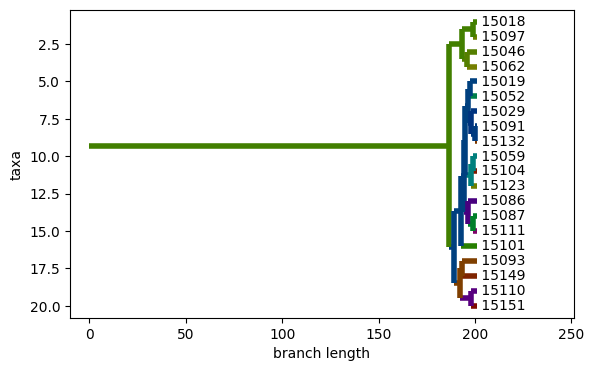

In [19]:
tp.tee(
    pylib.tree.draw_biopython_tree,
    distilled_tree,
    max_leaves=20,
    teeplot_outattrs={
        "max_leaves": "20",
        "notebook": "ne-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
        "type": "distilled-reference",
    },
)


In [20]:
distilled_tree = pylib.deap.history_to_tree_upgma(
    history, extant_nodes, correct_origin_times=False
)
pylib.tree.polymorphic_quartet_distance(reconstructed_tree, distilled_tree)


0.6364673884420867

# Differentia Magnitude


In [21]:
rd_data = dict(population[0].species_annotation.IterRankDifferentiaZip())


teeplots/./notebook=ne-inference+replicate=6+treatment=range-expansion+viz=scatterplot-differentia-magnitude+ext=.pdf


teeplots/./notebook=ne-inference+replicate=6+treatment=range-expansion+viz=scatterplot-differentia-magnitude+ext=.png


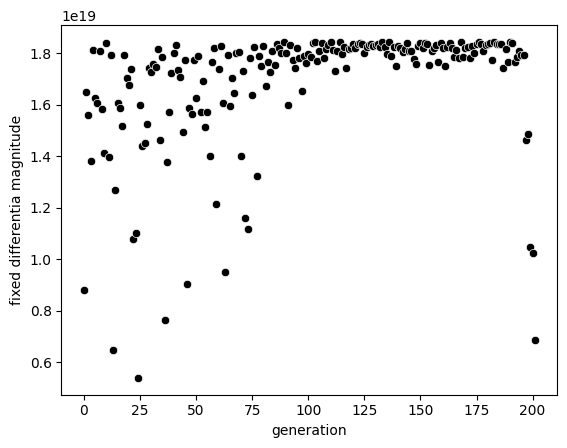

In [22]:
def scatterplot_differentia_magnitude():
#     plt.plot(*[*zip(*enumerate(MILL_NPOP_SEQ))])

    sns.scatterplot(
        x=rd_data.keys(),
        y=rd_data.values(),
        c="k",
    )

    for i, (a, b) in enumerate(it.pairwise(MILL_NPOP_SEQ)):
        if abs(a - b) > 2:
            plt.axvline(i + 1, c="white", lw=6)

            plt.axvline(i + 1, ls=":", c="red")
    for i, (a, b) in enumerate(it.pairwise(MILL_NTOURN_SEQ)):
        if a != b:
            plt.axvline(i + 1, c="white", lw=6)
            plt.axvline(i + 1, ls=":", c="red")

    plt.ylabel("fixed differentia magnitude")
    plt.xlabel("generation")

plt.rcdefaults()
plt.close('all')
plt.clf()
tp.tee(
    scatterplot_differentia_magnitude,
    teeplot_outattrs={
        "notebook": "ne-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
    },
)


teeplots/./notebook=ne-inference+replicate=6+treatment=range-expansion+viz=scatterplot-popsize-estimates+ext=.pdf


teeplots/./notebook=ne-inference+replicate=6+treatment=range-expansion+viz=scatterplot-popsize-estimates+ext=.png


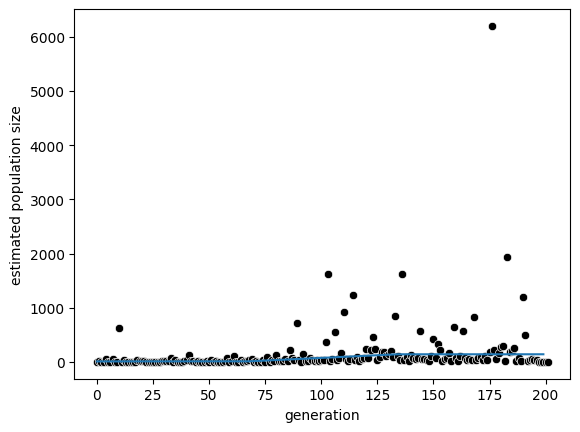

In [23]:
def scatterplot_popsize_estimates():
    plt.plot(*[*zip(*enumerate(MILL_NPOP_SEQ))])

    sns.scatterplot(
        x=rd_data.keys(),
       y=[
            -1 / np.log(x / 2**HSTRAT_DIFFERENTIA_WIDTH)
            for x in rd_data.values()
        ],
        c="k",
    )

    for i, (a, b) in enumerate(it.pairwise(MILL_NPOP_SEQ)):
        if abs(a - b) > 2:
            plt.axvline(i + 1, c="white", lw=6)

            plt.axvline(i + 1, ls=":", c="red")
    for i, (a, b) in enumerate(it.pairwise(MILL_NTOURN_SEQ)):
        if a != b:
            plt.axvline(i + 1, c="white", lw=6)
            plt.axvline(i + 1, ls=":", c="red")

    plt.ylabel("estimated population size")
    plt.xlabel("generation")

plt.rcdefaults()
plt.close('all')
plt.clf()
tp.tee(
    scatterplot_popsize_estimates,
    teeplot_outattrs={
        "notebook": "ne-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
    },
)


In [24]:
# TODO pool strata to create a running estimate with 95% confidence interval bands
import pandas as pd

df = pd.DataFrame(
    {
        "rank": rd_data.keys(),
        "differentia": rd_data.values(),
    }
)

df["normalized differentia"] = (
    df["differentia"] / 2**HSTRAT_DIFFERENTIA_WIDTH
)


In [25]:
# https://github.com/mmore500/hereditary-stratigraph-concept/blob/3ebe7a7f3f03c03592564a64b0024632888d8f1d/binder/popsize/maximum_likelihood_popsize_estimator_confidence_interval.ipynb
def solve_mle_popsize_ci_lb(
    observations: typing.List[float],
    *,
    confidence: float = 0.95,
) -> float:

    k = len(observations)
    hat_x = math.prod(observations)

    # use mle estimate as starting guess
    hat_n_mle = -k / math.log(hat_x)

    n_lb = sympy.Symbol(
        "n_\mathrm{lb}",
        positive=True,
        real=True,
    )

    return float(
        sympy.nsolve(
            2 * sympy.uppergamma(k, -n_lb * sympy.log(hat_x))
            - (confidence + 1) * sympy.gamma(k),
            hat_n_mle,
            verify=False,
        )
    )


def solve_mle_popsize_ci_ub(
    observations: typing.List[float],
    *,
    confidence: float = 0.95,
) -> float:

    k = len(observations)
    hat_x = math.prod(observations)

    # use mle estimate as starting guess
    hat_n_mle = -k / math.log(hat_x)

    n_lb = sympy.Symbol(
        "n_\mathrm{ub}",
        positive=True,
        real=True,
    )

    return float(
        sympy.nsolve(
            2 * sympy.uppergamma(k, -n_lb * sympy.log(hat_x))
            - (1 - confidence) * sympy.gamma(k),
            hat_n_mle,
            verify=False,
        )
    )


In [26]:
# Calculate the pooled running estimate
k = 10

df["running_ub"] = (
    df["normalized differentia"]
    .rolling(window=k)
    .apply(solve_mle_popsize_ci_ub)
)
df["running_lb"] = (
    df["normalized differentia"]
    .rolling(window=k)
    .apply(solve_mle_popsize_ci_lb)
)
df["population size"] = (
    df["normalized differentia"]
    .rolling(window=k)
    .apply(lambda x: -k / np.sum(np.log(x)))
)

k = 1
df["population size from singleton"] = (
    df["normalized differentia"]
    .rolling(window=k)
    .apply(lambda x: -k / np.sum(np.log(x)))
)


teeplots/./notebook=ne-inference+replicate=6+treatment=range-expansion+viz=plot-running-estimation+x=rank+y=population-size+ext=.pdf


teeplots/./notebook=ne-inference+replicate=6+treatment=range-expansion+viz=plot-running-estimation+x=rank+y=population-size+ext=.png


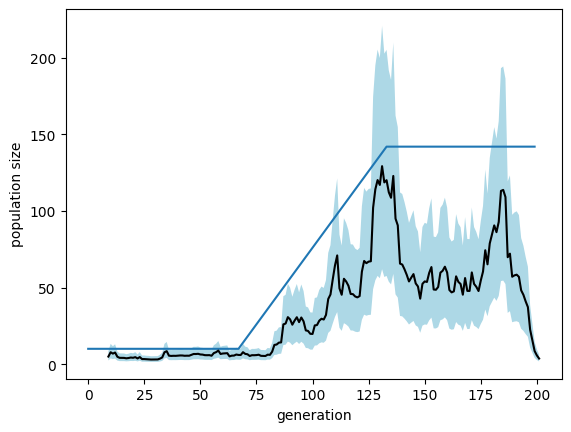

In [27]:
def plot_running_estimation(x, y, data):
    plt.plot(*[*zip(*enumerate(MILL_NPOP_SEQ))])

    sns.lineplot(
        data=data,
        x=x,
        y=y,
        c="k",
    )

    for i, (a, b) in enumerate(it.pairwise(MILL_NPOP_SEQ)):
        if abs(a - b) > 2:
            plt.axvline(i + 1, c="white", lw=6)
            plt.axvline(i + 1, ls=":", c="red")

    for i, (a, b) in enumerate(it.pairwise(MILL_NTOURN_SEQ)):
        if a != b:
            plt.axvline(i + 1, c="white", lw=6)
            plt.axvline(i + 1, ls=":", c="red")

    plt.fill_between(
        df["rank"], df["running_ub"], df["running_lb"], fc="lightblue"
    )
    plt.xlabel("generation")


plt.rcdefaults()
plt.close('all')
plt.clf()
tp.tee(
    plot_running_estimation,
    x="rank",
    y="population size",
    data=df,
    teeplot_outattrs={
        "notebook": "ne-inference",
        "replicate": str(MILL_REPLICATE),
        "treatment": MILL_TREATMENT_NAME,
    },
)


In [28]:
records = [
    {
        "notebook": "ne-inference",
        "replicate": MILL_REPLICATE,
        "treatment": MILL_TREATMENT_NAME,
        "first rank": first_rank,
        "population size estimate at first rank": df[
            df["rank"] == first_rank
        ].iloc[0]["population size"],
        "population size upper bound at first rank": df[
            df["rank"] == first_rank
        ].iloc[0]["running_ub"],
        "population size lower bound at first rank": df[
            df["rank"] == first_rank
        ].iloc[0]["running_lb"],
        "second rank": second_rank,
        "population size estimate at second rank": df[
            df["rank"] == second_rank
        ].iloc[0]["population size"],
        "population size upper bound at second rank": df[
            df["rank"] == second_rank
        ].iloc[0]["running_ub"],
        "population size lower bound at second rank": df[
            df["rank"] == second_rank
        ].iloc[0]["running_lb"],
        "nonoverlapping CI": min(
            df[df["rank"] == first_rank].iloc[0]["running_ub"],
            df[df["rank"] == second_rank].iloc[0]["running_ub"],
        )
        < max(
            df[df["rank"] == first_rank].iloc[0]["running_lb"],
            df[df["rank"] == second_rank].iloc[0]["running_lb"],
        ),
        "Mann-Whitney p": scipy_stats.mannwhitneyu(
            df.loc[
                (df["rank"] - first_rank).abs() < 15,
                "population size from singleton",
            ],
            df.loc[
                (df["rank"] - second_rank).abs() < 15,
                "population size from singleton",
            ],
        )[1],
    }
    for first_rank, second_rank in it.permutations([33, 100, 166], 2)
]
outdf = pd.DataFrame.from_records(records)
outdf["Mann-Whitney significant at alpha = 0.05"] = (
    outdf["Mann-Whitney p"] < 0.05
)
outdf["Mann-Whitney significant at alpha = 0.01"] = (
    outdf["Mann-Whitney p"] < 0.01
)
outdf.to_csv(
    kn.pack(
        {
            "a": "snapshot-comparisons-stats",
            "notebook": "ne-inference",
            "replicate": MILL_REPLICATE,
            "treatment": MILL_TREATMENT_NAME,
            "ext": ".csv",
        }
    )
)
outdf


,notebook,replicate,treatment,first rank,population size estimate at first rank,population size upper bound at first rank,population size lower bound at first rank,second rank,population size estimate at second rank,population size upper bound at second rank,population size lower bound at second rank,nonoverlapping CI,Mann-Whitney p,Mann-Whitney significant at alpha = 0.05,Mann-Whitney significant at alpha = 0.01
0,ne-inference,6,range-expansion,33,4.364858,7.457274,2.093119,100,19.697542,33.652863,9.445737,True,3.983954e-07,True,True
1,ne-inference,6,range-expansion,33,4.364858,7.457274,2.093119,166,52.311492,89.373155,25.085394,True,7.247674e-09,True,True
2,ne-inference,6,range-expansion,100,19.697542,33.652863,9.445737,33,4.364858,7.457274,2.093119,True,3.983954e-07,True,True
3,ne-inference,6,range-expansion,100,19.697542,33.652863,9.445737,166,52.311492,89.373155,25.085394,False,1.967877e-01,False,False
4,ne-inference,6,range-expansion,166,52.311492,89.373155,25.085394,33,4.364858,7.457274,2.093119,True,7.247674e-09,True,True
5,ne-inference,6,range-expansion,166,52.311492,89.373155,25.085394,100,19.697542,33.652863,9.445737,False,1.967877e-01,False,False
